<a href="https://colab.research.google.com/github/aninsung/Machine-Learning-Programming/blob/main/10%EC%A3%BC%EC%B0%A8/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

# List the contents of the extracted directory to identify the correct path
extracted_path = "/content/human_activity_recognition"
for root, dirs, files in os.walk(extracted_path):
    print(root)
    print(dirs)
    print(files)
    print("-" * 20)

In [2]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 749.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 103.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.6 MB/s eta 0:00:00


In [3]:
!unzip "/content/drive/MyDrive/UCI HAR Dataset.zip" -d /content/human_activity_recognition

Archive:  /content/drive/MyDrive/UCI HAR Dataset.zip
   creating: /content/human_activity_recognition/UCI HAR Dataset/
  inflating: /content/human_activity_recognition/UCI HAR Dataset/.DS_Store  
   creating: /content/human_activity_recognition/__MACOSX/
   creating: /content/human_activity_recognition/__MACOSX/UCI HAR Dataset/
  inflating: /content/human_activity_recognition/__MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: /content/human_activity_recognition/UCI HAR Dataset/activity_labels.txt  
  inflating: /content/human_activity_recognition/__MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: /content/human_activity_recognition/UCI HAR Dataset/features.txt  
  inflating: /content/human_activity_recognition/__MACOSX/UCI HAR Dataset/._features.txt  
  inflating: /content/human_activity_recognition/UCI HAR Dataset/features_info.txt  
  inflating: /content/human_activity_recognition/__MACOSX/UCI HAR Dataset/._features_info.txt  
  inflating: /content/human_activity_recognit

In [4]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, sep='\s+')
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = [
        'total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt',
        'body_acc_x_'+group+'.txt',  'body_acc_y_'+group+'.txt',  'body_acc_z_'+group+'.txt',
        'body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt'
    ]
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/human_activity_recognition/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/human_activity_recognition/UCI HAR Dataset/')

    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    # one-hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)

    print("Before scaling:", trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)

    # ===========================
    # 📏 StandardScaler 적용 부분
    # ===========================
    scaler = StandardScaler()

    # reshape to (samples*timesteps, features)
    n_samples_train, n_timesteps, n_features = trainX.shape
    n_samples_test = testX.shape[0]

    trainX_reshaped = trainX.reshape(-1, n_features)
    testX_reshaped = testX.reshape(-1, n_features)

    # fit scaler on training data only
    scaler.fit(trainX_reshaped)

    # transform both train and test
    trainX_scaled = scaler.transform(trainX_reshaped).reshape(n_samples_train, n_timesteps, n_features)
    testX_scaled = scaler.transform(testX_reshaped).reshape(n_samples_test, n_timesteps, n_features)

    print("After scaling:", trainX_scaled.shape, testX_scaled.shape)
    # ===========================

    return trainX_scaled, trainy, trainy_one_hot, testX_scaled, testy, testy_one_hot


# 데이터 불러오기
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

from sklearn.model_selection import train_test_split

X_train, X_val, y_train_one_hot_split, y_val_one_hot_split = train_test_split(
    trainX, trainy_one_hot, test_size=0.2, random_state=100
)

# Keep the original trainy and testy for evaluation purposes
# y_train and y_val are not needed for model training with one-hot encoded labels

print("✅ 데이터셋 준비 완료")
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", testX.shape)

<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2732011783.py:10: SyntaxWarning: invalid escape sequence '\s'
  dataframe = pd.read_csv(filepath, header=None, sep='\s+')
/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


Before scaling: (7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)
After scaling: (7352, 128, 9) (2947, 128, 9)
✅ 데이터셋 준비 완료
Train: (5881, 128, 9) Val: (1471, 128, 9) Test: (2947, 128, 9)


In [5]:
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 기본 차원 정의
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = y_train_one_hot_split.shape[1]

# === 🚀 정규화가 강화된 SimpleRNN 모델 ===

inputs = Input(shape=(n_timesteps, n_features))

# SimpleRNN 레이어 1
# dropout: 입력에 대한 드롭아웃
# recurrent_dropout: 순환 상태에 대한 드롭아웃 (과적합 방지에 매우 효과적)
x = SimpleRNN(128, return_sequences=True, activation='relu',
              dropout=0.2, recurrent_dropout=0.2)(inputs)

# SimpleRNN 레이어 2
x = SimpleRNN(64, return_sequences=True, activation='relu',
              dropout=0.2, recurrent_dropout=0.2)(x)

# 시퀀스 전체의 평균 특징을 추출
x = GlobalAveragePooling1D()(x)

x = Dense(128, activation='relu')(x)
# 드롭아웃 비율을 0.3 -> 0.4 로 높여 정규화 강화
x = Dropout(0.4)(x)
outputs = Dense(n_outputs, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 128, 128)       │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 128, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,110 (152.77 KB)

 Trainable params: 39,110 (152.77 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# 훈련에 사용할 콜백 정의
callbacks_list = [
    # 10 epoch 동안 val_loss가 개선되지 않으면 훈련 중지
    # restore_best_weights=True: 훈련이 끝나면 가장 좋았던 시점의 가중치로 복원
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),

    # 5 epoch 동안 val_loss가 개선되지 않으면 학습률을 0.5배 감소
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

# 모델 훈련
model_history = model.fit(
    x=X_train,
    y=y_train_one_hot_split,
    epochs=50,  # 최대 epoch를 50으로 늘리되, EarlyStopping이 조기 종료
    batch_size=32,
    validation_data=(X_val, y_val_one_hot_split),
    callbacks=callbacks_list  # 콜백 적용
)

Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.4506 - loss: 1.2726 - val_accuracy: 0.8858 - val_loss: 0.4404 - learning_rate: 0.0010
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.7523 - loss: 0.5924 - val_accuracy: 0.9279 - val_loss: 0.2189 - learning_rate: 0.0010
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.8187 - loss: 0.4222 - val_accuracy: 0.9279 - val_loss: 0.1724 - learning_rate: 0.0010
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.8559 - loss: 0.3540 - val_accuracy: 0.9279 - val_loss: 0.1694 - learning_rate: 0.0010
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.8622 - loss: 0.3320 - val_accuracy: 0.9307 - val_loss: 0.1490 - learning_rate: 0.0010
Epoch 6/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.8805 - loss: 0.2847 - val_accuracy: 0.9381 - val_loss: 0.1451 - learning_rate: 0.0010
Epoch 7/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.8838 - loss: 0.

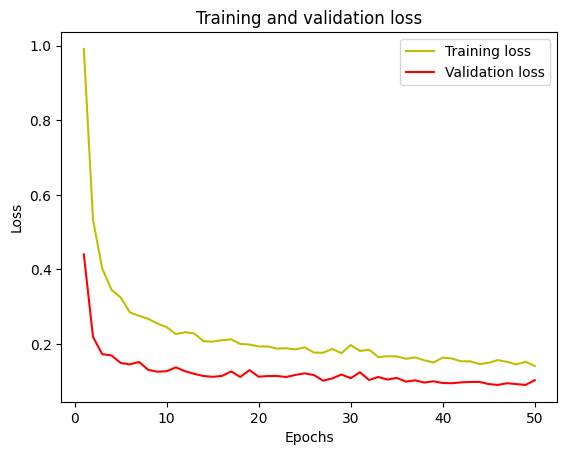

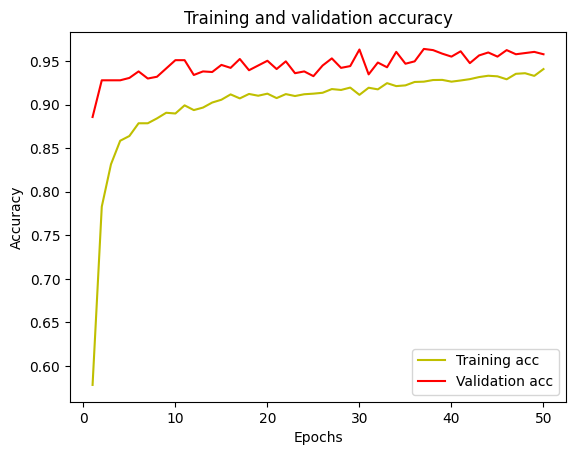

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
✅ 최종 테스트 성능 평가
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       496
           1       0.96      0.97      0.97       471
           2       0.99      0.96      0.98       420
           3       0.86      0.76      0.81       491
           4       0.84      0.89      0.86       532
           5       0.97      1.00      0.98       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947

Accuracy: 0.9298


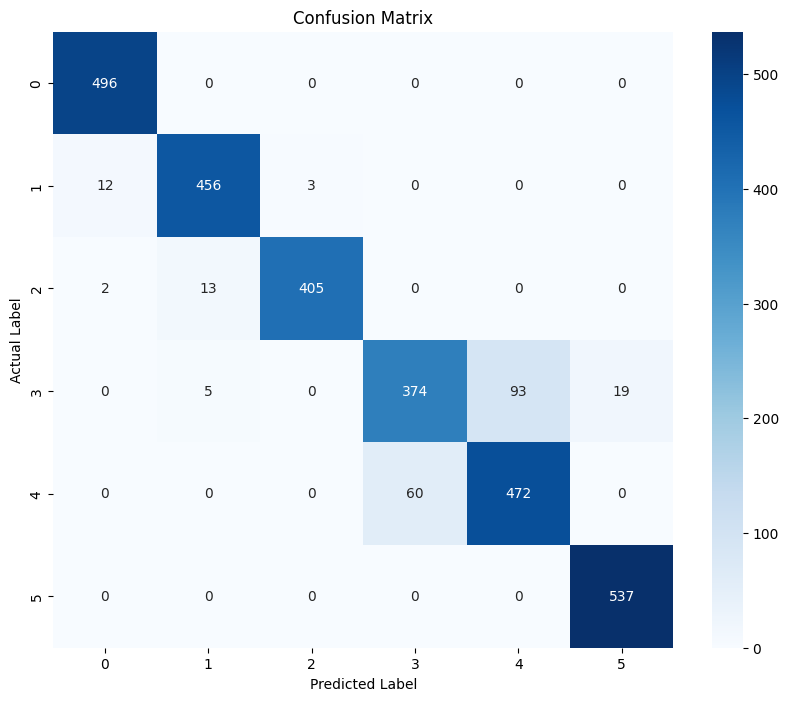

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np

# 1. 훈련/검증 손실 및 정확도 시각화
# (EarlyStopping으로 인해 epochs=50 보다 일찍 끝났을 수 있음)

# Loss
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# 2. 테스트 데이터로 최종 성능 평가
pred = model.predict(testX)
pred_classes = np.argmax(pred, axis=-1)

# testy는 (2947, 1) 형태이므로 1D 배열로 변환
testy_flat = testy.flatten()

print("✅ 최종 테스트 성능 평가")
# precision, recall, f1-score 확인
print(classification_report(testy_flat, pred_classes))

# 최종 정확도
print(f"Accuracy: {accuracy_score(testy_flat, pred_classes):.4f}")

# Confusion Matrix
cm = confusion_matrix(testy_flat, pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
[[496   0   0   0   0   0]
 [ 12 456   3   0   0   0]
 [  2  13 405   0   0   0]
 [  0   5   0 374  93  19]
 [  0   0   0  60 472   0]
 [  0   0   0   0   0 537]]
0.9297590770274856
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       496
           1       0.96      0.97      0.97       471
           2       0.99      0.96      0.98       420
           3       0.86      0.76      0.81       491
           4       0.84      0.89      0.86       532
           5       0.97      1.00      0.98       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947



<Axes: >

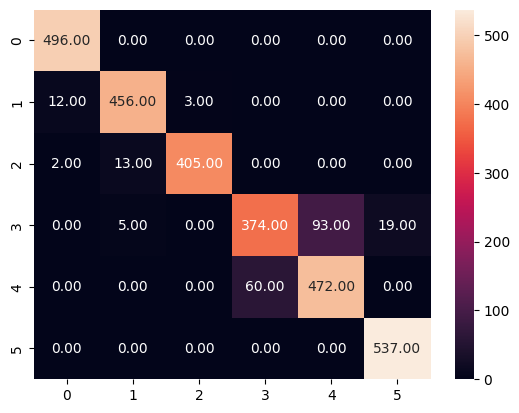

In [8]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
pred=model.predict(testX) # Corrected to use a single input tensor
pred=np.argmax(pred, axis=-1)
cm=confusion_matrix(testy,pred)
print(cm)
print(accuracy_score(testy,pred))
print(classification_report(testy,pred))
sns.heatmap(cm, annot=True, fmt = '.2f')